## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import yfinance as yf
from yahoofinancials import YahooFinancials
from pandas_datareader import data

## Data

In [2]:
bvsp_raw_data = yf.download('^BVSP', start='2016-01-01', end='2023-01-01', progress=False) # ibovespa
bsesn_raw_data = yf.download('^BSESN', start='2016-01-01', end='2023-01-01', progress=False) # S&P BSE SENSEX
ixic_raw_data = yf.download('^IXIC', start='2016-01-01', end='2023-01-01', progress=False) # Nasdaq
dji_raw_data = yf.download('^DJI', start='2016-01-01', end='2023-01-01', progress=False) # Dow Jones Industrial Average

In [3]:
bvsp_data = bvsp_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
bsesn_data = bsesn_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
ixic_data = ixic_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)
dji_data = dji_raw_data.rename({'Adj Close': 'Adj_Close'}, axis=1)

In [4]:
bvsp_data.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')

In [5]:
bvsp_data

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2016-01-04,43349.0,43349.0,42125.0,42141.0,42141.0,2976300
2016-01-05,42139.0,42534.0,42137.0,42419.0,42419.0,2557200
2016-01-06,42410.0,42410.0,41590.0,41773.0,41773.0,3935900
2016-01-07,41772.0,41772.0,40695.0,40695.0,40695.0,4032300
2016-01-08,40695.0,41218.0,40463.0,40612.0,40612.0,3221600
...,...,...,...,...,...,...
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500
2022-12-27,108739.0,109353.0,107418.0,108347.0,108347.0,11158100


In [6]:
round(bvsp_data.describe(), 2)

,Open,High,Low,Close,Adj_Close,Volume
count,1734.00,1734.00,1734.00,1734.00,1734.00,1734.00
mean,89804.78,90684.88,88948.66,89842.20,89842.20,6827986.85
std,22742.16,22862.20,22570.60,22719.74,22719.74,4178819.83
min,37501.00,38031.00,37046.00,37497.00,37497.00,0.00
25%,71409.00,72637.75,70787.50,71507.50,71507.50,3545800.00
50%,95385.00,96359.50,94352.50,95378.00,95378.00,5088750.00
75%,108922.50,110113.00,108071.25,108952.50,108952.50,10027525.00
max,130776.00,131190.00,129526.00,130776.00,130776.00,26029300.00


In [8]:
# You can use unadjusted closing prices to calculate returns, but adjusted closing prices save you some time and effort. 
# Adjusted prices are already adjusted for stock dividends, cash dividends and splits, 
#                                                                      which creates a more accurate return calculation.

bvsp_adj_close = bvsp_data['Adj_Close']
bsesn_adj_close = bsesn_data['Adj_Close']
ixic_adj_close = ixic_data['Adj_Close']
dji_adj_close = dji_data['Adj_Close']


rollingseries_bvsp_adj_close = bvsp_adj_close.rolling(window=7)
rollingmean_bvsp_adj_close = rollingseries_bvsp_adj_close.mean() #mean
rolling_std_bvsp_adj_close = rollingseries_bvsp_adj_close.std()

#print(rollingmean.head(10))
rollingseries_bsesn_adj_close = bsesn_adj_close.rolling(window=7)
rollingmean_bsesn_adj_close = rollingseries_bsesn_adj_close.mean()
rolling_std_bsesn_adj_close = rollingseries_bsesn_adj_close.std()

rollingseries_ixic_adj_close = ixic_adj_close.rolling(window=7)
rollingmean_ixic_adj_close = rollingseries_ixic_adj_close.mean()
rolling_std_ixic_adj_close = rollingseries_ixic_adj_close.std()

rollingseries_dji_adj_close = dji_adj_close.rolling(window=7)
rollingmean_dji_adj_close = rollingseries_dji_adj_close.mean()
rolling_std_dji_adj_close = rollingseries_dji_adj_close.std()



# Let's create a DataFrame that will contain data about the adjusted closing # prices for the selected cryptocurrencies in the given time period.
Close_Df = pd.DataFrame(columns=['bvsp','bsesn','ixic','dji'])
Close_Df['bvsp'] = round(bvsp_adj_close,2)
Close_Df['bsesn'] = round(bsesn_adj_close,2)
Close_Df['ixic'] = round(ixic_adj_close,2)
Close_Df['dji'] = round(dji_adj_close,2)

Close_Df


,bvsp,bsesn,ixic,dji
Date,,,,
2016-01-04,42141.0,25623.35,4903.09,17148.94
2016-01-05,42419.0,25580.34,4891.43,17158.66
2016-01-06,41773.0,25406.33,4835.76,16906.51
2016-01-07,40695.0,24851.83,4689.43,16514.10
2016-01-08,40612.0,24934.33,4643.63,16346.45
...,...,...,...,...
2022-12-23,109698.0,59845.29,10497.86,33203.93
2022-12-26,108738.0,60566.42,NaN,NaN
2022-12-27,108347.0,60927.43,10353.23,33241.56


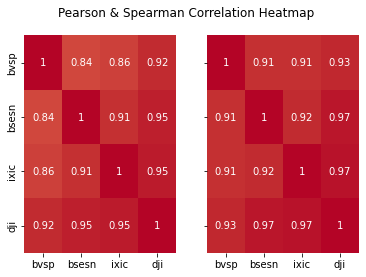

In [9]:
# Heatmap for Pearson and Spearman Correlation for Close Values between the Market Indices
close_corr_pearson = Close_Df.corr(method ='pearson')
close_corr_spearman = Close_Df.corr(method ='spearman')

cmap = 'coolwarm' #sns.diverging_palette(230, 20, as_cmap=True)

f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
f.suptitle('Pearson & Spearman Correlation Heatmap')

# Pearson
g1 = sns.heatmap(close_corr_pearson,cmap=cmap,cbar=False,ax=ax1, annot=True, vmin=-1, vmax=1)
g1.set_ylabel('')
g1.set_xlabel('')

# Spearman
g2 = sns.heatmap(close_corr_spearman,cmap=cmap,cbar=False,ax=ax2, annot=True, vmin=-1, vmax=1)
g2.set_ylabel('')
g2.set_xlabel('')

plt.show()

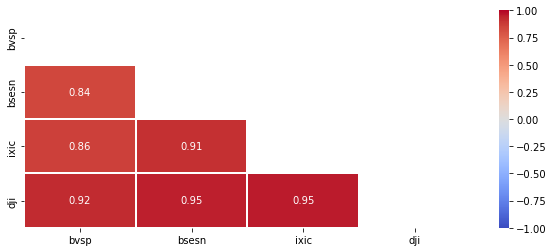

In [10]:
# All variables
plt.figure(5, figsize=(10, 4))

mask = np.triu(np.ones_like(close_corr_pearson, dtype=bool))

ax = sns.heatmap(close_corr_pearson, mask=mask,
                 xticklabels=close_corr_pearson.columns,
                 yticklabels=close_corr_pearson.columns,
                 annot=True, linewidths=.2,
                 cmap='coolwarm',
                 vmin=-1, vmax=1)

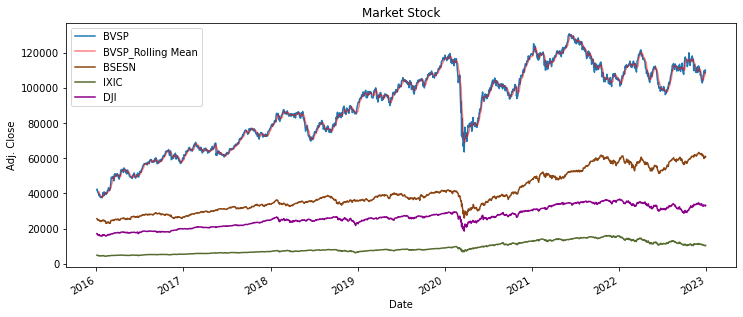

In [11]:
plt.figure(figsize=(12, 5))

bvsp_adj_close.plot(label = 'BVSP')
rollingmean_bvsp_adj_close.plot(alpha= 0.5, label = 'BVSP_Rolling Mean', color='r')
bsesn_adj_close.plot(label = 'BSESN', color='#8B4513')
# rollingmean_bsesn_adj_close.plot(alpha= 0.5, label = 'BSESN_Rolling Mean', color='#4B0082')
ixic_adj_close.plot(label = 'IXIC', color='#556B2F')
# rollingmean_ixic_adj_close.plot(alpha= 0.5, label = 'IXIC_Rolling Mean', color='green')
dji_adj_close.plot(label = 'DJI', color='#8B008B')
# rollingmean_dji_adj_close.plot(alpha= 0.5, label = 'DJI_Rolling Mean', color='r')

plt.legend(loc = 'best')
plt.title('Market Stock')
plt.ylabel('Adj. Close')
plt.show()

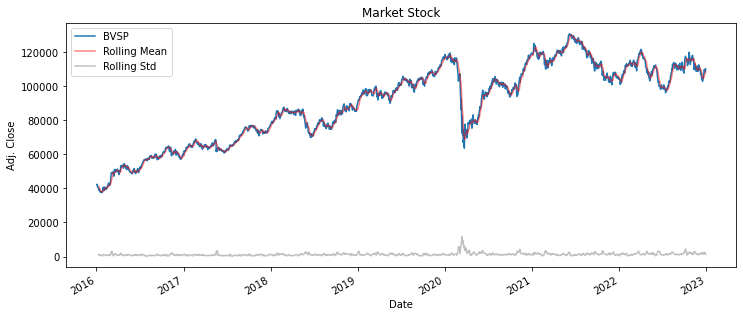

In [12]:
plt.figure(figsize=(12, 5))

bvsp_adj_close.plot(label = 'BVSP')
rollingmean_bvsp_adj_close.plot(color= 'red', alpha= 0.5, label = 'Rolling Mean')
rolling_std_bvsp_adj_close.plot(color= 'gray', alpha= 0.5, label = 'Rolling Std')

#bsesn_adj_close.plot(label = 'BSESN')
#rollingmean_bsesn_adj_close.plot(color= 'red', alpha= 0.5, label = 'Rolling Mean')

#ixic_adj_close.plot(label = 'IXIC')
#rollingmean_ixic_adj_close.plot(color= 'red', alpha= 0.5, label = 'Rolling Mean')

#dji_adj_close.plot(label = 'DJI')
#rollingmean_dji_adj_close.plot(color= 'red', alpha= 0.5, label = 'Rolling Mean')


plt.legend(loc = 'best')
plt.title('Market Stock')
plt.ylabel('Adj. Close')
plt.show()

In [17]:
# plotar o gráfico de candlestick
import plotly.graph_objects as go


trace1 = {
    'x': bvsp_data.index,
    'open': bvsp_data.Open,
    'close': bvsp_data.Adj_Close,
    'high': bvsp_data.High,
    'low': bvsp_data.Low,
    'type': 'candlestick',
    'name': 'bvsp_data',
    'showlegend': False
}
data = [trace1]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
fig.show()

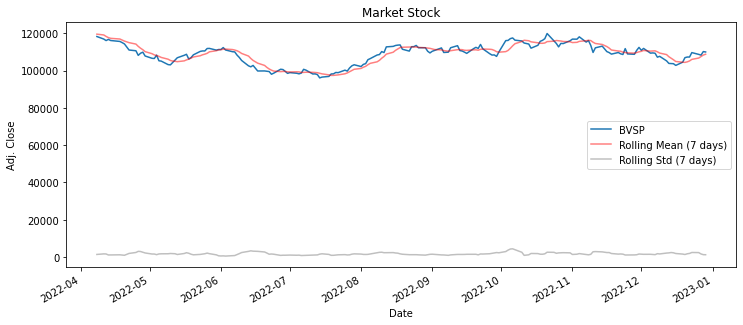

In [18]:
plt.figure(figsize=(12, 5))

bvsp_adj_close[-183:].plot(label = 'BVSP')
rollingmean_bvsp_adj_close[-183:].plot(color= 'red', alpha= 0.5, label = 'Rolling Mean (7 days)')
rolling_std_bvsp_adj_close[-183:].plot(color= 'gray', alpha= 0.5, label = 'Rolling Std (7 days)')

#bsesn_adj_close[-183:].plot(label = 'BSESN')
#rollingmean_bsesn_adj_close[-183:].plot(color= 'red', alpha= 0.5, label = 'Rolling Mean (14 days)')

#ixic_adj_close[-183:].plot(label = 'IXIC')
#rollingmean_ixic_adj_close[-183:].plot(color= 'red', alpha= 0.5, label = 'Rolling Mean (14 days)')

#dji_adj_close[-183:].plot(label = 'DJI')
#rollingmean_dji_adj_close[-183:].plot(color= 'red', alpha= 0.5, label = 'Rolling Mean (14 days)')


plt.legend(loc = 'best')
plt.title('Market Stock')
plt.ylabel('Adj. Close')
plt.show()

## Decomposition and stationarity check practicals

In [19]:
#test2
from statsmodels.tsa.stattools import adfuller



adft = adfuller(bvsp_adj_close,autolag="AIC")


output_df = pd.DataFrame({"Values":[adft[0], adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)


        Values                       Metric
0    -2.310096              Test Statistics
1     0.168733                      p-value
2    11.000000             No. of lags used
3  1722.000000  Number of observations used
4    -3.434153          critical value (1%)
5    -2.863220          critical value (5%)
6    -2.567664         critical value (10%)


In [20]:
# We can see that our data is not stationary from the fact that 
# our p-value is greater than 5 percent and 
# the test statistic is greater than the critical value. 
# We can also draw these conclusions from inspecting the data, 
# as we see a clear, increasing trend in the close_adj.


autocorrelation_lag1 = bvsp_adj_close.autocorr(lag=30)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = bvsp_adj_close.autocorr(lag=90)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = bvsp_adj_close.autocorr(lag=180)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = bvsp_adj_close.autocorr(lag=270)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.9321674189173834
Three Month Lag:  0.8446294384718377
Six Month Lag:  0.7662127736002862
Nine Month Lag:  0.7419694101616764


#

## Decomposition

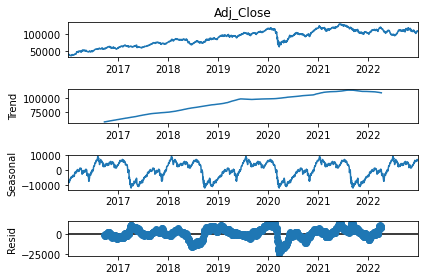

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(bvsp_adj_close,model='additive', period=365)
decompose.plot()
plt.show()

## Forecast

In [22]:
bvsp_adj_close_auxx = bvsp_adj_close

df = pd.DataFrame(data=bvsp_adj_close_auxx.values, columns=['Adj_Close'])

df['Date'] = bvsp_adj_close.index

df

,Adj_Close,Date
0,42141.0,2016-01-04
1,42419.0,2016-01-05
2,41773.0,2016-01-06
3,40695.0,2016-01-07
4,40612.0,2016-01-08
...,...,...
1729,109698.0,2022-12-23
1730,108738.0,2022-12-26
1731,108347.0,2022-12-27
1732,110237.0,2022-12-28


C:\Users\Pichau\AppData\Local\Temp/ipykernel_18244/2865321854.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pichau\AppData\Local\Temp/ipykernel_18244/2865321854.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



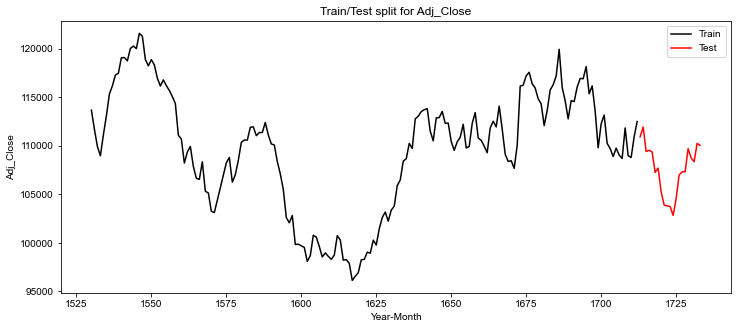

In [23]:
#Using only the most recent Date with Test Data

train = df[df['Date'] < pd.to_datetime("2022-12", format='%Y-%m')]
train['train'] = train['Adj_Close']
del train['Date']
del train['Adj_Close']
test = df[df['Date'] >= pd.to_datetime("2022-12", format='%Y-%m')]
del test['Date']
test['test'] = test['Adj_Close']
del test['Adj_Close']

plt.figure(figsize=(12, 5))
plt.plot(train[-183:], color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.title("Train/Test split for Adj_Close")
plt.ylabel("Adj_Close")
plt.xlabel('Year-Month')
plt.legend(loc = 'best')
sns.set()
plt.show()

Explicação do Modelo ARIMA (EM Construção)

https://miro.medium.com/max/640/1*64ZOjhR_jsZ9D-E51MKvBQ.webp

Auto-Regressive (p) -> Number of autoregressive terms.

Integrated (d) -> Number of nonseasonal differences needed for stationarity.

Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyper tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.



In [24]:
#Using ARIMA Model for forecast

from pmdarima.arima import auto_arima

model = auto_arima(train, 
                    start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, 
                    seasonal=True, error_action='warn', trace = True, suppress_warnings=True, stepwise=True, random_state=32, n_fits = 50, 
                    test= 'adf')
#model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=30716.851, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=30276.407, Time=2.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=30699.495, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=30107.848, Time=4.72 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=30024.548, Time=8.59 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=29975.492, Time=14.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=29917.541, Time=23.13 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=45.66 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=25.65 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=29928.867, Time=6.98 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=29919.224, Time=29.79 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=inf, Time=51.60 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=29918.001, Time=22.72 sec
 ARIMA(2,1,1)(5,1,0)[1

In [25]:
model.fit(train)
forecast, confint = model.predict(n_periods=len(test), return_conf_int=True)
forecast_df = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
confint_df= pd.DataFrame(confint)

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1713
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood              -14951.770
Date:                            Wed, 18 Jan 2023   AIC                          29917.541
Time:                                    18:07:40   BIC                          29955.609
Sample:                                         0   HQIC                         29931.634
                                           - 1713                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0841      0.010     -8.733      0.000      -0.103      -0.065
ar.S.L12      -0.7380      0.010    -71.880      0.000      -0.758      -0.718
ar.S.L24      -0.5915      0.015    -39.783      0.000      -0.621      -0.562
ar.S.L36      -0.4521      0.017    -27.303      0.000      -0.485      -0.420
ar.S.L48      -0.3189      0.018    -18.115      0.000      -0.353      -0.284
ar.S.L60      -0.1787      0.015    -11.870      0.000      -0.208      -0.149
sigma2      2.492e+06   3.69e+04     67.559      0.000    2.42e+06    2.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6784.65
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

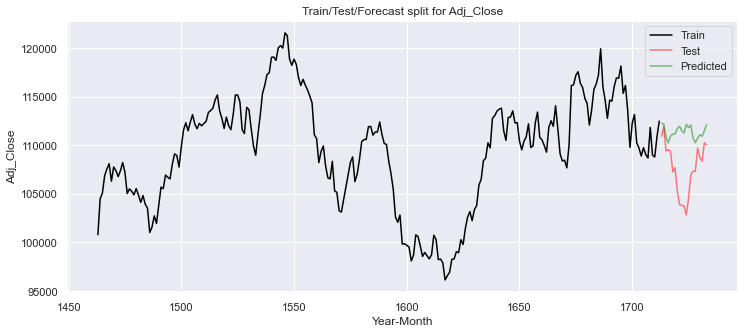

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(train[-250:], color = "black", label = 'Train')
plt.plot(test, color = "red", alpha = 0.5, label = 'Test')
plt.plot(forecast, color = 'green', alpha = 0.5, label = 'Predicted')
plt.title("Train/Test/Forecast split for Adj_Close")
plt.ylabel("Adj_Close")
plt.xlabel('Year-Month')
plt.legend(loc = 'best')
sns.set()
plt.show()

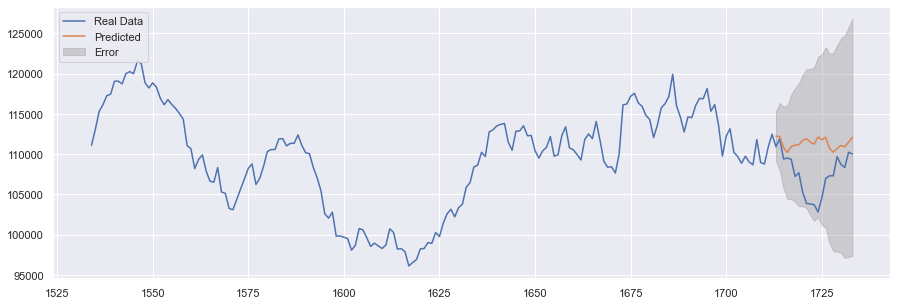

In [28]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df['Adj_Close'][-200:], label= 'Real Data')
ax.plot(forecast_df, label= 'Predicted')
ax.fill_between(forecast_df.index,
                confint_df[0],
                confint_df[1],
                color='grey',alpha=.3, label='Error')

plt.legend(loc='upper left')
plt.show()

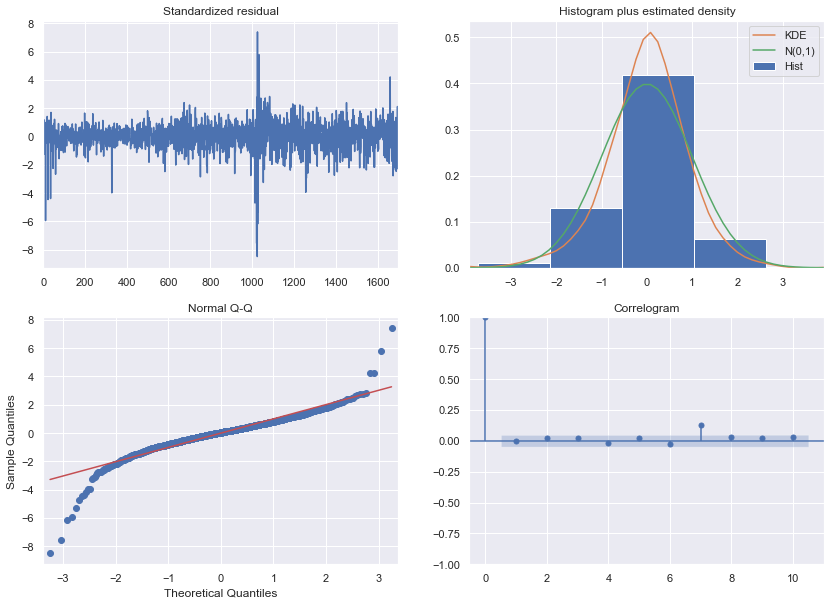

In [29]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


mse = mean_squared_error(test, forecast)
rms = sqrt(mse)
r2 = r2_score(test, forecast)

print("RMSE: ", rms)
print("R2 Score: ", r2)

RMSE:  4684.728207313978
R2 Score:  -2.2832433006925963


## ARIMA

In [42]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order=(p,d,q))
result_AR = model_arima.fit(train)

NameError: name 'p' is not defined

## SARIMAX

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(train, 
                        order=(2,1,2),
                        seasonal_order=(1,1,2,6))

result_sarimax = model_sarimax.fit(train)

ValueError: could not broadcast input array from shape (2,1) into shape (1,2)

In [ ]:
result_sarimax.summary()

## UNDER CONSTRUCTION...

In [ ]:
from IPython import display
display.Image("https://ps.w.org/easy-under-construction/assets/icon-256x256.png")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, seasonal_decompose

# Additive Decomposition
add_result = seasonal_decompose(bvsp_adj_close, model='additive',period=365)
# Multiplicative Decomposition 
mul_result = seasonal_decompose(bvsp_adj_close, model='multiplicative',period=365)

new_df_add = pd.concat([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed], axis=1)
new_df_add.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_add

In [ ]:
plt.figure(figsize=(20,14))
add_result.plot().suptitle('nAdditive Decompose', fontsize=5)
plt.show()

## ADfuller test for stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(bvsp_adj_close, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')